# DIGLM Tutorial

In this notebook we illustrate with a toy model the usage of the DIGLM class. 

The notebook is organized as follows:

1. Introduction;
2. Creation of a toy dataset;
3. Building the model and defining training functons;
4. Support function for plotting and sampling;
5. Training;
6. Results and final considerations


## 1.  Introduction

An object of the DIGLM class is a trainable model which allows to accomplish the two following tasks:

1. Reproduce the feature distribution thanks to a *normalizing flow* step mapping the features to a latent space with multivariate normal distribution features;
2. Perform regression (linear, logistic and much more) with a Generalized Linear Model (GLM).

The idea comes from the article by [E. Nalisnick et al.](https://arxiv.org/abs/1902.02767) where the DIGLM model and algorithm characteristics is described and test on some examples are provided.

The two parts that constitute the algorithm are trained in a single feed-forward step of a semi-supervised training:
given the features observation $ \{x\}_i ^N $ and their true labels $ \{y\}_i ^N $, the loss function minimized is

$- \sum_i \log{p(y|x; \theta, \beta)} + \lambda \log{p(x; \theta)}$

where:

1. $\beta$ are the weights of the glm;
2. $\theta$ are the parameters that maps the distibution of $x$ to the space of the latent variables $z$ through the *normalizing flow*. The distribution of $z$ is set to be a multivariate normal distribution with dimension equal to the space of the feature vectors;
3. $\lambda$ is a hyper-parameter which weights the importance in the training of the two different parts of the loss: the first term indeed is used to solve the regression problem; the second one trains the *normalizing flow*. 




In [2]:
##### UNCOMMENT TO RUN ON GOOGLE COLAB #####
#! git clone https://github.com/MarcoRiggirello/diglm.git

#import os
#import sys
#sys.path.append('diglm/src')

import tensorflow as tf
from tensorflow import Variable, ones, zeros
from tensorflow_probability import glm
from tensorflow_probability import distributions as tfd
from tensorflow.keras import metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from diglm import DIGLM
from spqr import NeuralSplineFlow as NSF

## 2. Toy dataset

The feature vectors $x_1$ and $x_2$ are sampled from a uniform distribution $U[-1, 1]$.
The response function $y(x_1, x_2): \mathbb{R}^2 \rightarrow \{0, 1\}$ is:
$
\begin{cases}
1 \text{ if } x_1 \cdot x_2 > \dfrac{1}{x_1 \cdot x_2} \\
0 \text{ elsewise} \\
\end{cases}
$

The sampled vectors and the response are transformed to a `tf.data.Dataset`.

<AxesSubplot:xlabel='x1', ylabel='x2'>

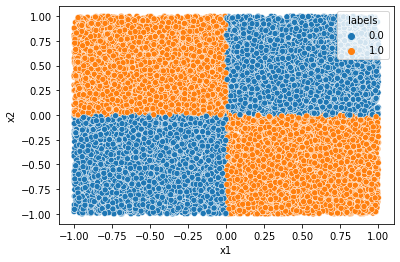

In [3]:
BATCH_SIZE = 128
DATASET_SIZE = BATCH_SIZE * 128

X1 = np.random.uniform(low=-1, high=1, size=DATASET_SIZE)
X2 = np.random.uniform(low=-1, high=1, size=DATASET_SIZE)
response = lambda x1, x2: x1 * x2 > 1 / (x1 * x2) 

df = pd.DataFrame(np.stack((response(X1, X2), X1, X2), axis=1),
                  columns=['labels','x1', 'x2'])
sns.scatterplot(data=df, x='x1', y='x2', hue='labels')

## 3. Utilities: transforming datasets, sampling of distributions and plotting

We define some functions to transform our data into TesnorFlow datasets for automatic batching and parallelization; to extract sample from the transformed distributions and to plot them.

In [7]:
def to_tf_dataset(df, columns, dtype='float32', batch_size=32):
    """
    util function to transform a pandas.DataFrame into a
    batched tf.data.Dataset.
    
    """

    tf_ds = tf.data.Dataset.from_tensor_slices(df[columns].astype(dtype))
    tf_ds = tf_ds.prefetch(tf.data.experimental.AUTOTUNE)
    tf_ds = tf_ds.cache()
    tf_ds = tf_ds.batch(batch_size)
    return tf_ds

def sampling(size=1000):
    """
    returns a sample of the transformed disribution and its computed
    response through glm evaluation.

    """
    trans_sample = trans_distr.sample(size)
    mean_sample, var_sample, grad_sample  = diglm(trans_sample)
    x1, x2 = np.split(trans_sample.numpy(), 2, axis=1)
    x1 = np.concatenate(x1)
    x2 = np.concatenate(x2)
    mean = np.concatenate(mean_sample.numpy().T)
    return mean, x1, x2

def plot(name, counter=None): 
    """
    plotting function that gets some samples from the norm. flow
    inverse distribution and the calculated response and plots it.
    """
    mean, x1, x2 = sampling(size=DATASET_SIZE)
    ex_df = pd.DataFrame(np.stack((mean, x1, x2), axis=1),
                         columns=['labels', 'x1', 'x2'])
    ax = sns.scatterplot(data=ex_df, x='x1', y='x2', hue='labels')
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.1, 3.1)
    if counter is not None: # used to track the training epoch
        plt.text(0.9*(-3.5), 0.9*3.1, f'epoch = {counter}')
    plt.savefig(name)
    plt.show() 

bandiera = to_tf_dataset(df, ['x1', 'x2'], batch_size=BATCH_SIZE)
bandiera_l = to_tf_dataset(df, ['labels'], dtype='int32', batch_size=BATCH_SIZE)

## 4. Building the DIGLM 

We initialize our diglm model with:

1. a NeuralSplineFlow object as bijector with two splits (there are only two variables
2. a `tf.glm.Bernoulli()` as glm to realize the logistic regression.


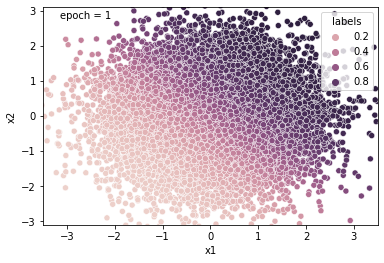

In [8]:
my_glm = glm.Bernoulli()
neural_spline_flow = NSF(splits=2)
diglm = DIGLM(neural_spline_flow, my_glm, 2)

train_dict = [{'labels': batch_l,
              'features': batch_ft}
              for batch_l, batch_ft in zip(bandiera_l, bandiera)]

trans_distr = tfd.TransformedDistribution(distribution=tfd.MultivariateNormalDiag(
                    loc=zeros([diglm.num_features]),
                    scale_diag=ones([diglm.num_features])
                ),
                bijector=diglm.bijector)

# let's visualize a sample from the inverse distribution of the bijector
# before training.
plot('my_fig.png', counter=1)

## 5. Training

First, we define a train step, where the loss and its gradient are calculated and the training variables of the model are updated accordingly. We follow the [keras tutorial](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).


In [9]:
@tf.function
def train_step(optimizer, target_sample, weight=.1):
    """
    Train step function for the diglm model. Implements the basic steps for computing
    and updating the trainable variables of the model. It also
    calculates the loss on training and validation samples.

    """

    with tf.GradientTape() as tape:
        # calculating loss and its gradient of training data
        loss = -tf.reduce_mean(diglm.weighted_log_prob(target_sample, scaling_const=weight))
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

Now we are ready to train the model!

In [10]:
# we define a suitable metric
accuracy = metrics.BinaryAccuracy()

def update_accuracy():
    """
    util function to update the binary accuracy metric
    to evaluate the algorithm performances.
    """
    accuracy.reset_state()
    y_true = train_dict[0]['labels']
    y_pred, y_var, grad = diglm(train_dict[0]['features'])
    accuracy.update_state(y_true, y_pred.numpy().T)
    history['accuracy'].append(accuracy.result().numpy())

# hyper parameters
LR = 1e-3
NUM_EPOCHS = 20
learning_rate = tf.Variable(LR, trainable=False)
optimizer = tf.keras.optimizers.Adam(learning_rate)

loss = 0
history = {'accuracy': [], 'loss': []}
fig_list = []

weight = 0.5

# training loop on epochs
for epoch in range(NUM_EPOCHS):
    print(f'Epoch = {epoch+1} Loss = {loss:.3f}.')
    # train batch per batch
    for i, batch in enumerate(train_dict):
        loss = train_step(optimizer, batch, weight=weight)

       # updating loss and accuracy
        if i % 10 == 0:
            update_accuracy()
            history['loss'].append(loss)
    # saving figures
    name = f'fig{epoch}.jpeg'
    fig_list.append(name)

Epoch = 1 Loss = 0.000.
Epoch = 2 Loss = 1.510.
Epoch = 3 Loss = 1.370.
Epoch = 4 Loss = 1.265.
Epoch = 5 Loss = 1.238.
Epoch = 6 Loss = 1.219.
Epoch = 7 Loss = 1.191.
Epoch = 8 Loss = 1.147.
Epoch = 9 Loss = 1.118.


KeyboardInterrupt: 

## 6. Results

To illustrate the results of the training, we plot:

1. a gif illustrating how the algorithm learnt both to reproduce the feature distribution and the response
2. The loss and accuracy history


In [27]:
from plot_utils import make_gif

make_gif(fig_list, "diglm_example.gif", duration=0.3)
